<a href="https://colab.research.google.com/github/YuriArduino/Project_Noosphera/blob/main/Easy_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.  Preparando o ambiente

##1.1.   Instalando bibliotecas

In [1]:
!pip install -q easyocr opencv-python sympy pydantic pillow python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 88.4 MB/s eta 0:00:00


##1.2. Importando DB

In [2]:
! git clone https://github.com/YuriArduino/Project_Noosphera/

Cloning into 'Project_Noosphera'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 1.83 MiB | 15.57 MiB/s, done.
Resolving deltas: 100% (2/2), done.


##1.3.  Importanto Fontes

In [3]:
# ============================================================
# ✅ Instalação e Validação da Fonte "Calibri" via Carlito (Ubuntu)
# ============================================================

import os
import subprocess
from PIL import Image, ImageDraw, ImageFont

print(" Instalando fontes Carlito (substituto oficial da Calibri)...")
subprocess.run(["sudo", "apt-get", "install", "-y", "fonts-crosextra-carlito"], check=False)

print("\n Listando fontes instaladas contendo 'carlito'...")
result = subprocess.run(["fc-list"], stdout=subprocess.PIPE, text=True)
fonts = [line for line in result.stdout.split("\n") if "carlito" in line.lower()]

if fonts:
    print("✅ Fontes Carlito encontradas:\n")
    for f in fonts:
        print("•", f)
else:
    print("⚠️ Nenhuma fonte Carlito encontrada. Algo falhou.")
    fonts = []

# ------------------------------------------------------------
# ✅ Selecionar automaticamente a melhor fonte encontrada
# ------------------------------------------------------------
font_path = None
preferred_names = ["Carlito-Regular.ttf", "Carlito-Regular"]

for f in fonts:
    for name in preferred_names:
        if name.lower() in f.lower():
            font_path = f.split(":")[0].strip()
            break

if font_path:
    print(f"\n✅ Fonte principal selecionada:\n{font_path}")
else:
    print("\n⚠️ Não consegui determinar o caminho exato da fonte. Verifique manualmente.")
    font_path = None

# ------------------------------------------------------------
# ✅ Testar carregamento com PIL para garantir compatibilidade
# ------------------------------------------------------------
if font_path:
    try:
        test_font = ImageFont.truetype(font_path, 32)

        # Criar imagem de teste
        img = Image.new("RGB", (800, 200), color=(240, 240, 240))
        draw = ImageDraw.Draw(img)
        draw.text(
            (20, 60),
            "Teste de Fonte: Carlito (compatível com Calibri)",
            font=test_font,
            fill=(10, 10, 10)
        )
        img.show()
        print("\n✅ A fonte foi carregada e renderizada com sucesso!")
    except Exception as e:
        print("❌ Erro ao carregar a fonte com PIL:", e)
else:
    print("⚠️ Teste de renderização não executado.")

# ------------------------------------------------------------
# ✅ Exportar variável global pronta para uso no pipeline OCR
# ------------------------------------------------------------
print("\n✅ Variável pronta para uso no OCR:")
print("font_path =", font_path)


 Instalando fontes Carlito (substituto oficial da Calibri)...

 Listando fontes instaladas contendo 'carlito'...
✅ Fontes Carlito encontradas:

• /usr/share/fonts/truetype/crosextra/Carlito-Bold.ttf: Carlito:style=Bold
• /usr/share/fonts/truetype/crosextra/Carlito-BoldItalic.ttf: Carlito:style=Bold Italic
• /usr/share/fonts/truetype/crosextra/Carlito-Italic.ttf: Carlito:style=Italic
• /usr/share/fonts/truetype/crosextra/Carlito-Regular.ttf: Carlito:style=Regular

✅ Fonte principal selecionada:
/usr/share/fonts/truetype/crosextra/Carlito-Regular.ttf

✅ A fonte foi carregada e renderizada com sucesso!

✅ Variável pronta para uso no OCR:
font_path = /usr/share/fonts/truetype/crosextra/Carlito-Regular.ttf


##1.4. Importanto Bibliotecas

In [4]:
import easyocr

import numpy as np
import cv2
import re
import os
import matplotlib.pyplot as plt

from PIL import ImageFont, ImageDraw, Image
from google.colab.patches import cv2_imshow

font_path = "/usr/share/fonts/truetype/crosextra/Carlito-Regular.ttf"

##1.5. mostrando imagens

In [5]:
# ============================================================
# ✅ Instalação da biblioteca de conversão de PDF para Imagem
# ============================================================
!pip install -q pdf2image
!sudo apt-get install -y -qq poppler-utils

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121249 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.12_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.12) ...
Setting up poppler-utils (22.02.0-2ubuntu0.12) ...
Processing triggers for man-db (2.10.2-1) ...


PDFs encontrados: ['/content/Project_Noosphera/Noosphera_data/pdf_teste_1.pdf', '/content/Project_Noosphera/Noosphera_data/pdf_teste_2.pdf']

--- Processando e exibindo páginas do PDF: pdf_teste_1.pdf ---
Exibindo página 1


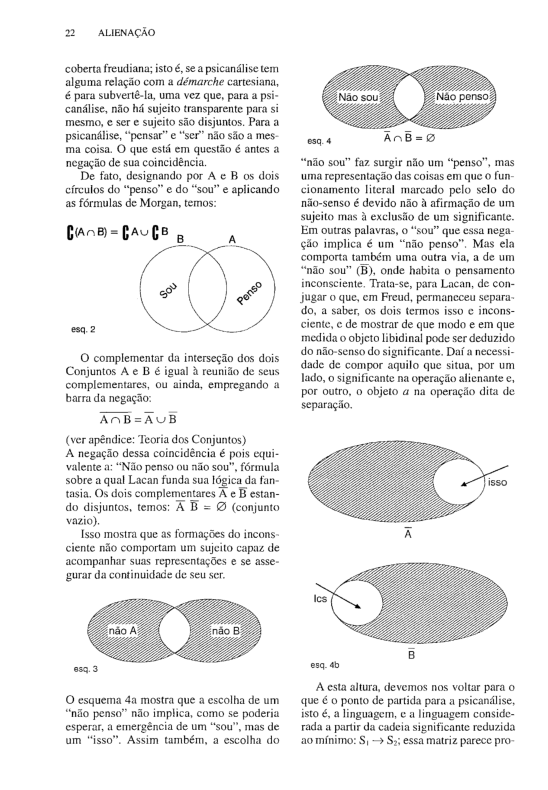

Exibindo página 2


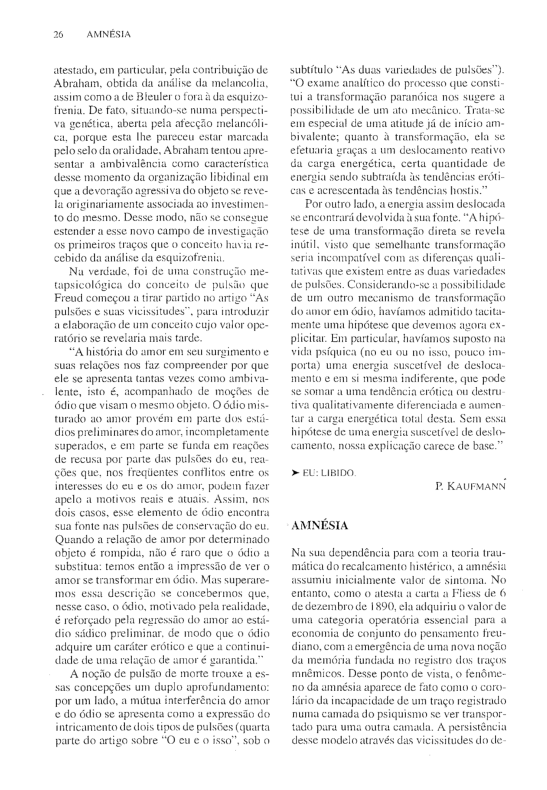

--- Processando e exibindo páginas do PDF: pdf_teste_2.pdf ---
Exibindo página 1


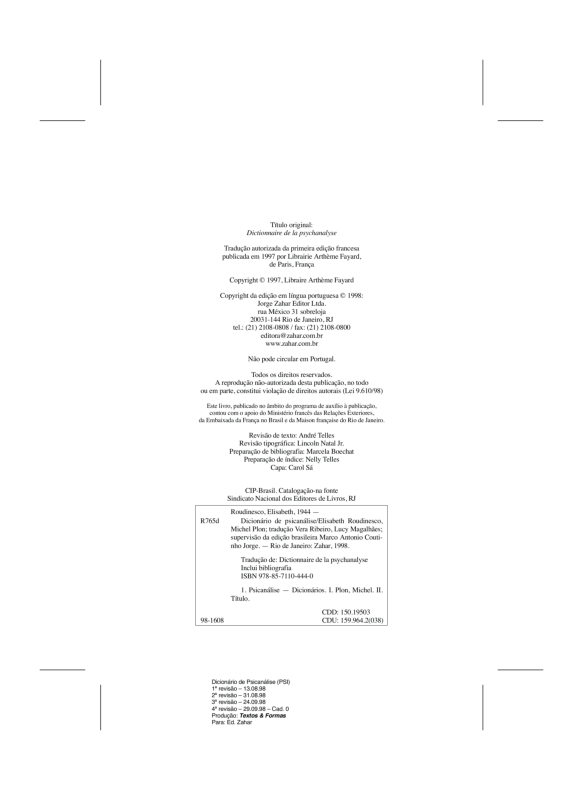

Exibindo página 2


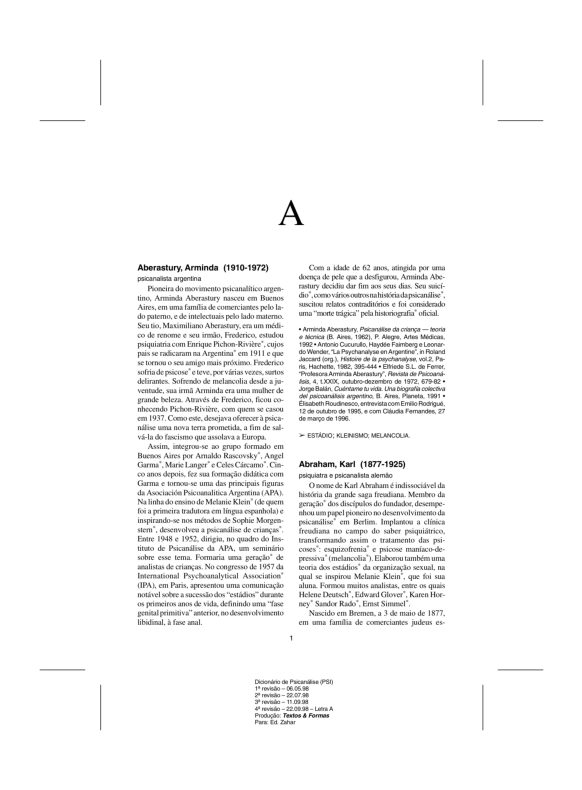

In [6]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from pdf2image import convert_from_path # <-- Importação necessária

# ============================================================
# ✅ Sua função original para mostrar imagens (sem alterações)
# ============================================================
def mostrar(img):
  """Exibe uma imagem OpenCV no Colab."""
  fig = plt.gcf()
  fig.set_size_inches(20, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# ============================================================
# ✅ Lógica para processar e exibir os PDFs
# ============================================================
projeto = "/content/Project_Noosphera/Noosphera_data"
caminho = [os.path.join(projeto, f) for f in os.listdir(projeto)]

# Filtra apenas os caminhos que terminam com .pdf
pdfs = [f for f in caminho if f.endswith('.pdf')]
print(f"PDFs encontrados: {pdfs}\n")

# Loop para processar cada arquivo PDF encontrado
for pdf_path in pdfs:
  print(f"--- Processando e exibindo páginas do PDF: {os.path.basename(pdf_path)} ---")
  try:
    # Converte o PDF em uma lista de imagens (uma por página)
    # dpi=200 aumenta a resolução para melhor qualidade do OCR depois
    images_from_pdf = convert_from_path(pdf_path, dpi=200)

    # Itera sobre cada página convertida
    for i, page_image in enumerate(images_from_pdf):
      print(f"Exibindo página {i + 1}")

      # Converte a imagem do formato PIL (RGB) para o formato OpenCV (BGR)
      # 1. Converte para um array NumPy
      # 2. Altera o espaço de cores de RGB para BGR
      opencv_image = cv2.cvtColor(np.array(page_image), cv2.COLOR_RGB2BGR)

      # Usa sua função para mostrar a imagem da página
      mostrar(opencv_image)

  except Exception as e:
    print(f"Ocorreu um erro ao processar o arquivo {pdf_path}: {e}")

#2.  Reconhecimento de texto

## 2.1. Modelo Pydantic para Configuração

leitor = easyocr.Reader(lang_list=['pt'], gpu=True)
print("\n".join(leitor.readtext(imagem_1, detail=0)))